In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F654917%2F1157728%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240429%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240429T053913Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0b8c4b2973ed60fbb975cedb7d17fd25b3dd4cf9fb06dcbbcd665c3d1e6970a5afdb5cce2e6684629fbd8dc99158f051feecddab932351e55628f27046d9f093356a781f2c29912f6b12c44ee7f150375f8acce1eae977b7c5bd848c3b3e1642c6bad904c63e9a863866d77ad0ee9326c91df4e38ecd014b3596f2a829fbdccfc4904c32167a2f9cf5dd0be9e629d7cea38f47698bcff59c0aaecd65dbeaae69da5751a1da708cad58f60c397bf836de4234c8e66dfa6fcb262d8ad8b02c83b89353a567182d45b9bef63f18e802b89887609354540967f27a58cbc07e202eac206bb68457f914dc51cfb67538a4e8b3eee9cedbab9df2add319d24e46f6816d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 184440080 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import shutil
print(os.listdir("/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset"))

['Train', 'Val', 'Prediction']


In [ ]:
TRAIN_PATH = "/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Train"
VAL_PATH = "/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Val"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image

In [ ]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=(224,224,3)))

model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(1,activation="sigmoid"))

model.compile(loss=keras.losses.binary_crossentropy,optimizer = "adam",metrics=["accuracy"])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                   

In [ ]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
)
test_dataset = image.ImageDataGenerator(rescale = 1./255)


In [ ]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Train',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 288 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [ ]:
validation_generator = test_dataset.flow_from_directory(
    '/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Val',
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 60 images belonging to 2 classes.


In [ ]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch = 8,
    epochs = 1,
    validation_data = validation_generator,
    validation_steps = 2
)

<ipython-input-12-196876ac0482>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


8/8 [==============================] - 133s 16s/step - loss: 0.6691 - accuracy: 0.6055 - val_loss: 0.6496 - val_accuracy: 0.6833


In [ ]:
model.save("Detection_Covid_19.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = load_model("Detection_Covid_19.h5")

In [ ]:
import os

In [ ]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [ ]:
y_actual = []
y_test = []

In [ ]:
for i in os.listdir("/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Val/Normal"):
    img = image.load_img("/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Val/Normal/"+i, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    p = model.predict(img)
    predicted_class = np.argmax(p, axis=1)[0]
    y_test.append(predicted_class)
    y_actual.append(0)  # Assuming 0 represents 'Normal' class

1/1 [==============================] - 0s 88ms/step


In [ ]:
for i in os.listdir("/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Val/Covid"):
    img = image.load_img("/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Val/Covid/"+i, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    p = model.predict(img)
    predicted_class = np.argmax(p, axis=1)[0]
    y_test.append(predicted_class)
    y_actual.append(1)

1/1 [==============================] - 0s 90ms/step


In [ ]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y_actual,y_test)

In [ ]:
import seaborn as sns

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
class_names = ["Covid-19","Normal"]

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="plasma"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[30  0]
 [30  0]]


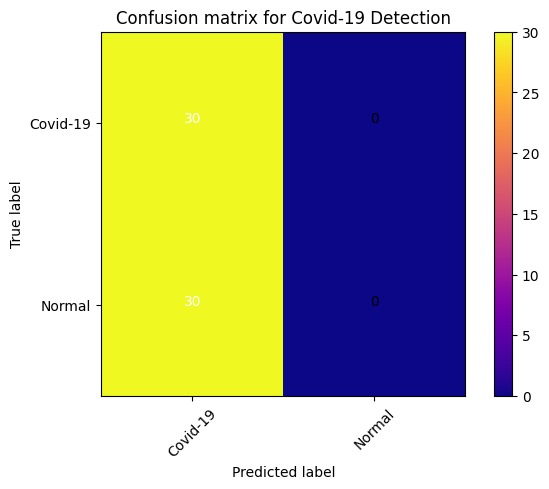

In [ ]:
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix for Covid-19 Detection',cmap="plasma")


In [ ]:

history = hist
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


1/1 [==============================] - 0s 89ms/step
This Xray Image is of a possible COVID-19 patient
Prediction Of Our Model :  Positive For Covid-19


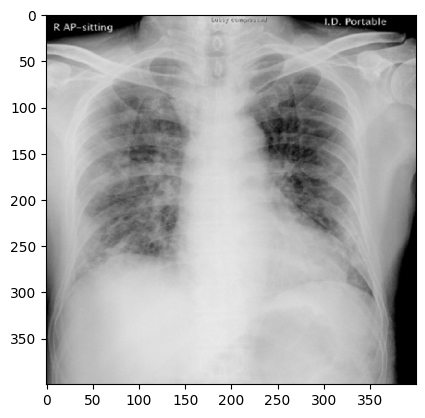

In [ ]:
import numpy as np
import cv2
from keras.preprocessing import image
import matplotlib.pyplot as plt

xtest_image = image.load_img('/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Prediction/ryct.2020200034.fig5-day4.jpeg', target_size=(224, 224))
xtest_image = image.img_to_array(xtest_image)
xtest_image = np.expand_dims(xtest_image, axis=0)
results = model.predict(xtest_image)

imggg = cv2.imread('/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Prediction/ryct.2020200034.fig5-day7.jpeg')
print("This Xray Image is of a possible COVID-19 patient")
imggg = np.array(imggg)
imggg = cv2.resize(imggg, (400, 400))
plt.imshow(imggg)

if results[0][0] < 0.5:
    prediction = 'Positive For Covid-19'
else:
    prediction = 'Negative for Covid-19'

print("Prediction Of Our Model : ", prediction)


1/1 [==============================] - 0s 141ms/step
This Xray Image is of Negative covid-19 patient
Prediction Of Our Model :  Negative for Covid-19


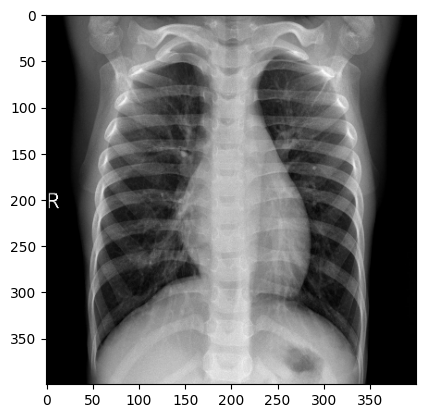

In [ ]:
import numpy as np

from keras.preprocessing import image
xtest_image = image.load_img('/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Prediction/NORMAL2-IM-0357-0001.jpeg', target_size = (224, 224))
xtest_image = image.img_to_array(xtest_image)
xtest_image = np.expand_dims(xtest_image, axis = 0)
results = model.predict(xtest_image)


imggg = cv2.imread('/content/drive/MyDrive/Chest X-Ray Images for covid-19 detection/Dataset/Prediction/NORMAL2-IM-0357-0001.jpeg')
print("This Xray Image is of Negative covid-19 patient")
imggg = np.array(imggg)
imggg = cv2.resize(imggg,(400,400))

plt.imshow(imggg)

if results[0][0] == 0:
    prediction = 'Positive For Covid-19'
else:
    prediction = 'Negative for Covid-19'
print("Prediction Of Our Model : ",prediction)